In [12]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer # type: ignore
import matplotlib.pyplot as plt


## Read fingerprint file and experimental file

In [2]:
receptors = pd.read_csv(
    "/Users/xiaomuou620/Desktop/PRIVATE_DATA/hallucinome.csv"
) 
fingerprints = pd.read_csv('../../data/ExperimentData/MACCS_fingerprints.csv')
print(receptors.head())
print(fingerprints.head())
print(fingerprints.shape)



  receptor gprotein        drug    Emax  Emax_SE    TCoeff  TCoeff_SE  \
0    5HT1A      Gi1   25C-NBOMe  999.00   999.00       NaN        NaN   
1    5HT1A      Gi1    25I-NBMD   18.62     2.06  8.878197   0.201061   
2    5HT1A      Gi1   25I-NBOMe   24.53     3.28  7.947086   0.195392   
3    5HT1A      Gi1  25T7-NBOMe   22.00     3.87  7.457872   0.217788   
4    5HT1A      Gi1  4-AcO-MALT   38.93     5.16  7.417719   0.148907   

    logEmEC  logEmEc_Lower  logEmEc_Upper   pEC50  pEC50_SE  N  
0       NaN            NaN            NaN  999.00    999.00  3  
1  8.879980       8.529060       9.225551    7.61      0.30  3  
2  7.949698       7.607359       8.284201    6.56      0.28  3  
3  7.462423       7.078398       7.832796    6.12      0.30  3  
4  7.420284       7.158531       7.674340    5.83      0.20  3  
         Name  0  1  2  3  4  5  6  7  8  ...  157  158  159  160  161  162  \
0        5-HT  0  0  0  0  0  0  0  0  0  ...    1    1    1    0    1    1   
1  4-AcO-MALT

### Experimental data processing

For all the data, only use the highest Emax as input for each molecule-receptor binding info.

Every molecule-receptor binding involves g proteins, we only take largest Emax value among the involving g proteins.

In [3]:
# replace 999 in Emax with 0
receptors["Emax"] = receptors["Emax"].replace(999, 0)
# print(receptors.head())

# collect receptors for each drug
receptor_emax_mapping = (
    receptors.groupby(["drug", "receptor"])["Emax"].max().reset_index()
)
# print(receptor_emax_mapping.head())

# pivot the table to have drugs as rows and receptors as columns
receptor_emax_mapping_pivot = receptor_emax_mapping.pivot(
    index="drug", columns="receptor", values="Emax"
).reset_index()
print(receptor_emax_mapping_pivot.head())

receptor_emax_mapping_pivot.fillna(0, inplace=True)
print(receptor_emax_mapping_pivot.shape)

receptor        drug      5HT1A       5HT1B   5HT1D   5HT1E       5HT1F  \
0          25C-NBOMe  13.047601    0.000000   61.56    0.00    0.000000   
1           25I-NBMD  27.200000   84.239297   91.94  105.26  102.099230   
2          25I-NBOMe  45.370000    0.000000   53.65   33.92   64.596780   
3         25T7-NBOMe  31.991315    0.000000   31.81    0.00   69.116817   
4         4-AcO-MALT  50.677696  126.170618  101.04  115.53  102.552716   

receptor   5HT2A  5HT2B   5HT2C  5HT5A  ...  Alpha2B  Alpha2C  Beta1AR  \
0         126.52  67.19   98.15   0.00  ...      0.0      0.0      0.0   
1         102.02  45.49   79.79   0.00  ...      0.0      0.0      0.0   
2         108.36  72.04  104.43  27.97  ...      0.0      0.0      0.0   
3          99.15  53.73   94.85  36.81  ...      0.0      0.0      0.0   
4         102.61  68.11  110.35  43.88  ...      0.0      0.0      0.0   

receptor  Beta2AR  Beta3AR  DRD1   DRD2   DRD3  DRD4   DRD5  
0             0.0      0.0   0.0  50.60   

### Fingerprint data processing

In [4]:
# Extract the names (first column)
drug_names_fingerprints = fingerprints['Name']
fingerprints_detail = fingerprints.drop('Name', axis=1)  # Drop the name column by index

# Create a dictionary where names are keys and fingerprints are lists of values
# csv_dict = {name: fingerprint.tolist() for name, fingerprint in zip(drug_names_fingerprints, fingerprints_detail.values)}


### Merge feature and values

To ensure the order of features and values match based on molecules.

Here, labels have 44 lines and fingerprints have 43 lines, including the header.

Since I cannot find the category and SMILES of METALLED, when merging the data, METALLED data will be disgarded.

In [5]:
# merge receptor_emax_mapping_pivot with fingerprints
# data_merged = pd.merge(
#     receptor_emax_mapping_pivot, fingerprints, left_on="drug", right_on="Name"
# ).drop(columns=["Name"])

data_merged = pd.merge(
    fingerprints.assign(Name_lower=fingerprints["Name"].str.strip().str.lower()),
    receptor_emax_mapping_pivot.assign(
        drug_lower=receptor_emax_mapping_pivot["drug"].str.strip().str.lower()
    ),
    left_on="Name_lower",
    right_on="drug_lower",
    how="left",
)

data_merged.drop(columns=["Name_lower", "drug_lower"], inplace=True)

# data_merged.to_csv(
#     "/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file_realval.csv", index=False
# )
print(data_merged.head())
print(data_merged.shape)

         Name  0  1  2  3  4  5  6  7  8  ...  Alpha2B  Alpha2C  Beta1AR  \
0        5-HT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
1  4-AcO-MALT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
2   5-MeO-DMT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
3  5-MeO-DALT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
4  5-MeO-DiPT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   

   Beta2AR  Beta3AR  DRD1    DRD2    DRD3   DRD4   DRD5  
0      0.0      0.0   0.0  102.81  100.11   0.00   0.00  
1      0.0      0.0   0.0   61.99   85.60   0.00   0.00  
2      0.0      0.0   0.0   58.32   98.14  82.27   0.00  
3      0.0      0.0   0.0   85.37   77.33  96.92  20.34  
4      0.0      0.0   0.0    0.00    0.00  23.29   0.00  

[5 rows x 194 columns]
(43, 194)


# Training

In [6]:
# Drop the 'receptor' column
data_merged = data_merged.drop(columns=["Name", "drug"])
print(data_merged.head())

   0  1  2  3  4  5  6  7  8  9  ...  Alpha2B  Alpha2C  Beta1AR  Beta2AR  \
0  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
1  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
2  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
3  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
4  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   

   Beta3AR  DRD1    DRD2    DRD3   DRD4   DRD5  
0      0.0   0.0  102.81  100.11   0.00   0.00  
1      0.0   0.0   61.99   85.60   0.00   0.00  
2      0.0   0.0   58.32   98.14  82.27   0.00  
3      0.0   0.0   85.37   77.33  96.92  20.34  
4      0.0   0.0    0.00    0.00  23.29   0.00  

[5 rows x 192 columns]


Since MACCS only has 166 bits and the first bit 0 always unset and may be ignored. Only bits 1-166 will be set

In [7]:
X = data_merged.iloc[:, 1:167]
y = data_merged.iloc[:, 167:]

print(X.shape, y.shape)
print(X.head())
print(y.head())


(43, 166) (43, 25)
   1  2  3  4  5  6  7  8  9  10  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    0    1    1    1    1   
1  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
3  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    0  
4    1    0  

[5 rows x 166 columns]
        5HT1A       5HT1B   5HT1D   5HT1E       5HT1F   5HT2A   5HT2B   5HT2C  \
0  100.092869  103.121191  100.18  100.00  100.492669  100.03  100.00  101.54   
1   50.677696  126.170618  101.04  115.53  102.552716  102.61   68.11  110.35   
2   99.975644  133.393687  111.07  105.54   97.499582  101.18   78.36  122.64   
3   96.610000  120.412851  102.32  101.26   85.529384   94.33 

## Multioutput Regression Task + Nested CV

In [8]:
import optuna
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Example data (replace with your own)
# X = np.random.randint(0, 2, size=(100, 165))  # 100 molecules, 165 features
# Y = np.random.rand(100, 9)  # 100 molecules, 9 receptor values

# Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_scores = []



def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    # Evaluate using inner CV
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, Y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf.fit(X_train_inner, y_train_inner)
        Y_pred_inner = rf.predict(X_val_inner)
        mse_inner = mean_squared_error(
            Y_val_inner, Y_pred_inner, multioutput="raw_values"
        )
        inner_scores.append(np.mean(mse_inner))

    return np.mean(inner_scores)


# Outer loop
for train_idx, test_idx in outer_cv.split(X):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Use Optuna to find the best hyperparameters
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)  # Perform 50 trials (adjust as needed)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on test set
    Y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred, multioutput="raw_values")  # Per receptor
    outer_scores.append(mse)

# Average MSE across outer folds
mean_outer_score = np.mean(outer_scores, axis=0)
print(f"Mean MSE per receptor: {mean_outer_score}")


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-05 13:21:32,941] A new study created in memory with name: no-name-98ac78c9-fffe-47e9-9e7d-eb5948bc70ed
[I 2025-01-05 13:21:33,420] Trial 0 finished with value: 920.3052300060408 and parameters: {'n_estimators': 156, 'max_depth': 20, 'min_samples_split': 6}. Best is trial 0 with value: 920.3052300060408.
[I 2025-01-05 13:21:33,724] Trial 1 finished with value: 950.5754776574784 and parameters: {'n_estimators': 87, 'max_depth': 20, 'min_samples_split': 2}. Best is trial 0 with value: 920.3052300060408.
[I 2025-01-05 13:21:34,180] Trial 2 finished with value: 944.7176727357611 and parameters: {'n_estimators': 147, 'max_depth': 10, 'min_samples_split': 4}. Best is trial 0 with value: 920.3052300060408.


Mean MSE per receptor: [ 482.76314386  810.71600855  569.32494841 1259.02901954  529.70256031
  541.74585761  853.31345063  545.55381564  771.22501467  615.80676076
  967.42234822 1199.53647005  905.20207967  665.92521543  685.79381284
  615.17848142  681.67142218  267.38459277  313.21717973  767.97028046
  462.67751057 1340.60046095 1448.86057137 1411.63475746  728.04823849]


In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    explained_variance_score,
    mean_absolute_error,
)

# Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    inner_scores = []
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        rf.fit(X_train_inner, y_train_inner)
        y_pred_inner = rf.predict(X_val_inner)
        mse_inner = mean_squared_error(
            y_val_inner, y_pred_inner, multioutput="raw_values"
        )
        inner_scores.append(np.mean(mse_inner))

    return np.mean(inner_scores)


# Outer loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test, y_pred, multioutput="raw_values")
    evs = explained_variance_score(y_test, y_pred, multioutput="raw_values")
    mae = mean_absolute_error(y_test, y_pred, multioutput="raw_values")

    outer_scores.append((mse, r2, evs, mae))



[I 2025-01-06 11:55:40,149] A new study created in memory with name: no-name-8b47a723-da2d-42ee-a71c-b8cb0f2e3b6a
[I 2025-01-06 11:55:40,533] Trial 0 finished with value: 943.1504334664866 and parameters: {'n_estimators': 109, 'max_depth': None, 'min_samples_split': 4}. Best is trial 0 with value: 943.1504334664866.
[I 2025-01-06 11:55:40,752] Trial 1 finished with value: 920.5897665593587 and parameters: {'n_estimators': 69, 'max_depth': None, 'min_samples_split': 5}. Best is trial 1 with value: 920.5897665593587.
[I 2025-01-06 11:55:41,132] Trial 2 finished with value: 939.6095493401396 and parameters: {'n_estimators': 123, 'max_depth': None, 'min_samples_split': 4}. Best is trial 1 with value: 920.5897665593587.
[I 2025-01-06 11:55:41,499] Trial 3 finished with value: 949.0367232456631 and parameters: {'n_estimators': 115, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 1 with value: 920.5897665593587.
[I 2025-01-06 11:55:41,866] Trial 4 finished with value: 925.909586154647

Mean MSE per receptor: [ 480.50681983  805.59775112  578.17434729 1257.49903012  543.52862487
  525.20917874  804.15012617  543.21180177  799.44171466  627.07811399
  893.88858655 1184.05684096  941.64017713  650.65603901  677.62221213
  603.15377415  725.93354102  273.76696136  322.38071064  797.53600224
  457.67781542 1336.92677618 1521.43236509 1639.11003957  759.33876972]
Mean R² per receptor: [ 0.59988735  0.14973752  0.28697554 -0.67688448  0.24811755  0.33383448
  0.2437155   0.22178564  0.37347629  0.65153237  0.31714042  0.161094
 -0.05218338  0.35013638 -0.08981372  0.42754969  0.03187792 -0.02857143
 -0.05090489  0.30866909  0.48774701  0.19674719  0.027881    0.00688893
  0.39992868]
Mean Explained Variance per receptor: [ 6.45692384e-01  4.17156135e-01  3.68995016e-01 -4.94532880e-02
  5.66083135e-01  4.53834059e-01  3.68661695e-01  2.75172480e-01
  4.49767729e-01  7.20937339e-01  4.30692626e-01  2.38996344e-01
  5.99889534e-02  4.36753337e-01  2.02919010e-01  5.18754947e-

# Evaluation and Visualization

In [ ]:
# Average scores across outer folds
mean_outer_scores = np.mean(outer_scores, axis=0)
print(f"Mean MSE per receptor: {mean_outer_scores[0]}")
print(f"Mean R² per receptor: {mean_outer_scores[1]}")
print(f"Mean Explained Variance per receptor: {mean_outer_scores[2]}")
print(f"Mean MAE per receptor: {mean_outer_scores[3]}")

In [16]:
receptor_names = y.columns
mean_mse = mean_outer_scores[0]
mean_r2 = mean_outer_scores[1]
mean_evs = mean_outer_scores[2]
mean_mae = mean_outer_scores[3]

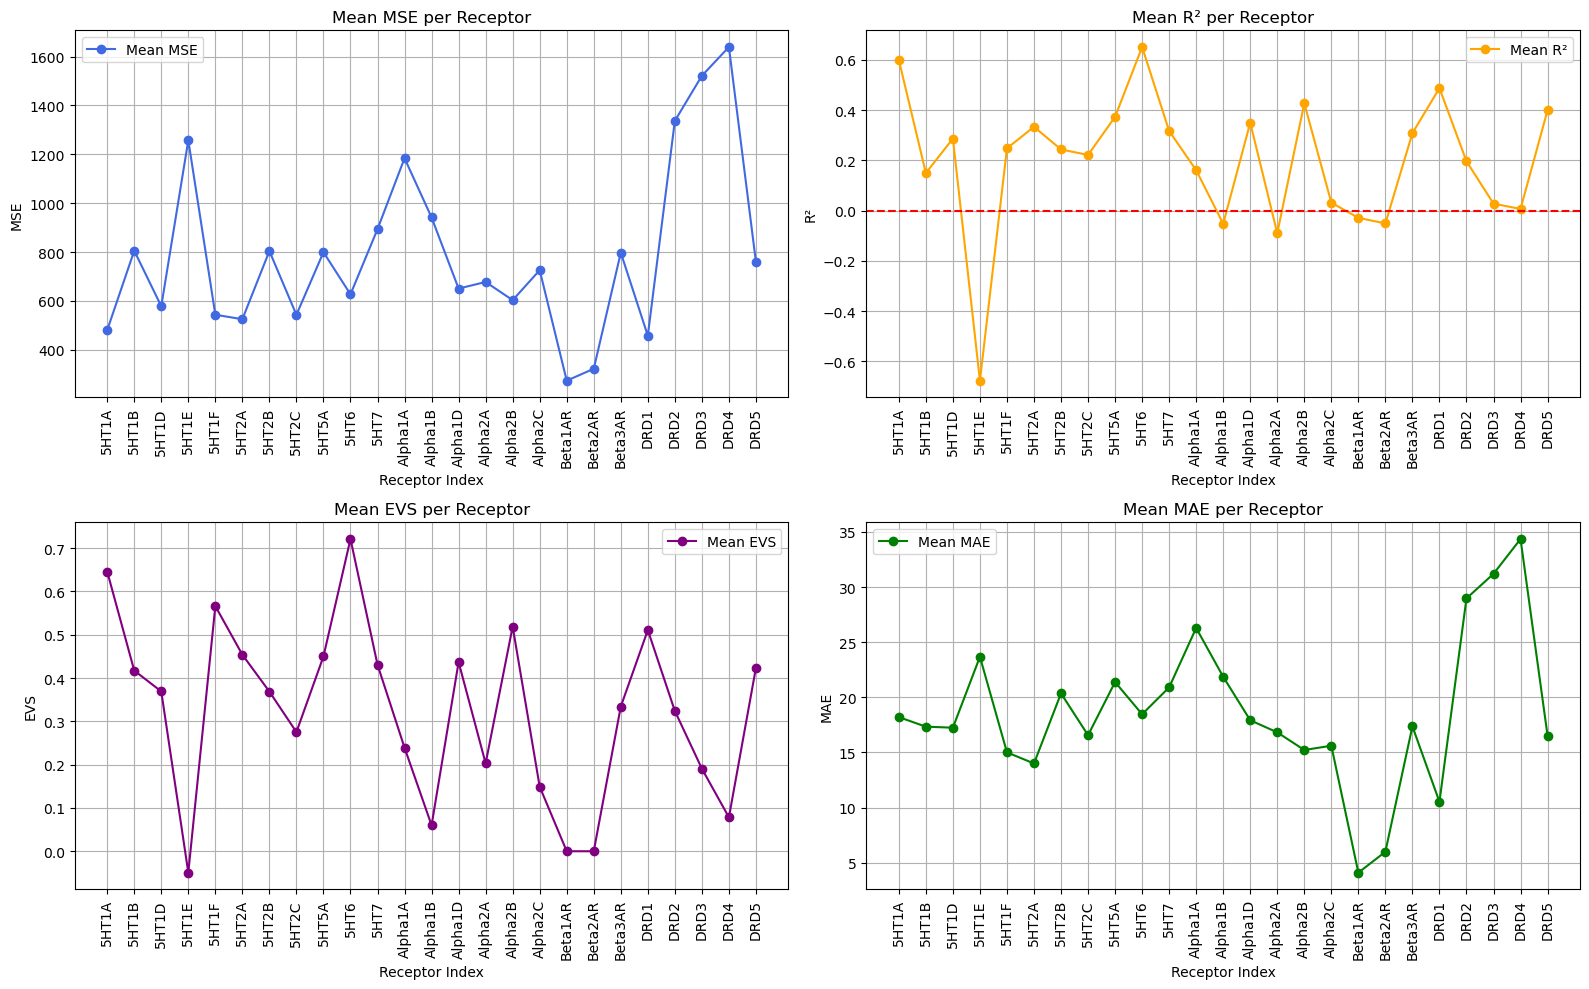

In [23]:
# Plot
plt.figure(figsize=(16, 10))

# MSE Line Plot
plt.subplot(2, 2, 1)
plt.plot(receptor_names, mean_mse, marker="o", color="royalblue", label="Mean MSE")
plt.title("Mean MSE per Receptor")
plt.xlabel("Receptor Index")
plt.xticks(rotation=90)
plt.ylabel("MSE")
plt.grid(True)
plt.legend()

# R² Line Plot
plt.subplot(2, 2, 2)
plt.plot(receptor_names, mean_r2, marker="o", color="orange", label="Mean R²")
plt.title("Mean R² per Receptor")
plt.xlabel("Receptor Index")
plt.xticks(rotation=90)
plt.ylabel("R²")
plt.axhline(0, color="red", linestyle="--")  
plt.grid(True)
plt.legend()

# evs Line Plot
plt.subplot(2, 2, 3)
plt.plot(receptor_names, mean_evs, marker="o", color="purple", label="Mean EVS")
plt.title("Mean EVS per Receptor")
plt.xlabel("Receptor Index")
plt.xticks(rotation=90)
plt.ylabel("EVS")
plt.grid(True)
plt.legend()

# MAE Line Plot
plt.subplot(2, 2, 4)
plt.plot(receptor_names, mean_mae, marker="o", color="green", label="Mean MAE")
plt.title("Mean MAE per Receptor")
plt.xlabel("Receptor Index")
plt.xticks(rotation=90)
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
